In [11]:
pip install tensorflow


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached tensorflow-2.8.0-cp37-cp37m-manylinux2010_x86_64.whl (497.5 MB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached grpcio-1.44.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Using cached tensorflow_io_gcs_filesystem-0.24.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.1 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (1

In [68]:
# Distribution functions
from scipy.stats import norm


# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

### True Parameters


In [14]:
true_alpha = 0.1
true_beta = 0.1
true_sigma0 = 0.2
risk_free_rate = 0.05

### Vol and Option Pricing Functions


In [15]:
def option_vol_from_surface(moneyness,time_to_maturity):
    return true_sigma0+true_alpha*time_to_maturity+true_beta*np.square(moneyness-1)

def call_option_price(moneyness, time_to_maturity, option_vol):
    d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    return N_d1 - moneyness * np.exp(-risk_free_rate*time_to_maturity) * N_d2



### 2.3. Data Generation


In [16]:
N = 10000

Ks = 1+0.25*np.random.randn(N)
Ts = np.random.random(N)
Sigmas = np.array([option_vol_from_surface(k,t)for k,t in zip(Ks,Ts)])
Ps = np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])


In [21]:
Y = Ps

X = np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)], axis=1)


dataset = pd.DataFrame(np.concatenate([Y.reshape(-1,1), X], axis=1),
                       columns=['Price', 'Moneyness', 'Time', 'Vol'])

In [23]:
dataset.shape

(10000, 4)

In [25]:
pd.set_option("precision",3)
dataset.describe()

,Price,Moneyness,Time,Vol
count,10000.000,10000.000,1.000e+04,10000.000
mean,0.177,1.003,4.984e-01,0.256
std,0.136,0.251,2.878e-01,0.030
min,0.000,0.143,1.273e-04,0.200
25%,0.072,0.832,2.516e-01,0.231
50%,0.157,1.005,4.956e-01,0.256
75%,0.252,1.174,7.493e-01,0.281
max,0.863,2.307,1.000e+00,0.460


### 3.2. Data Visualization

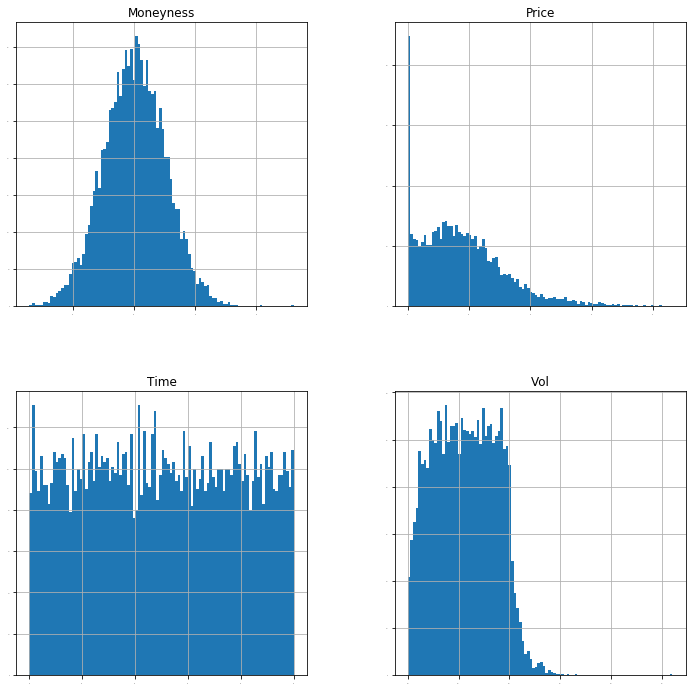

In [36]:
dataset.hist(bins=100,sharex = False,sharey=False,xlabelsize=1,ylabelsize=1,figsize=(12,12));

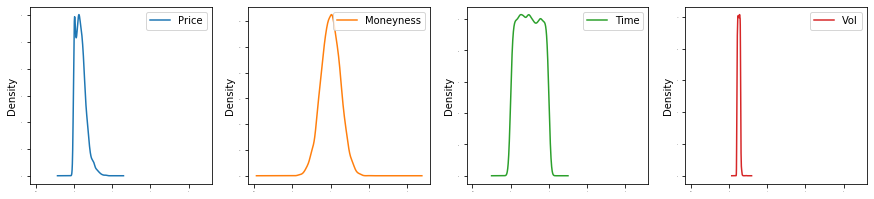

In [38]:
dataset.plot(kind="density",subplots=True,layout=(4,4),sharex=True,legend=True,fontsize=1,figsize=(15,15));

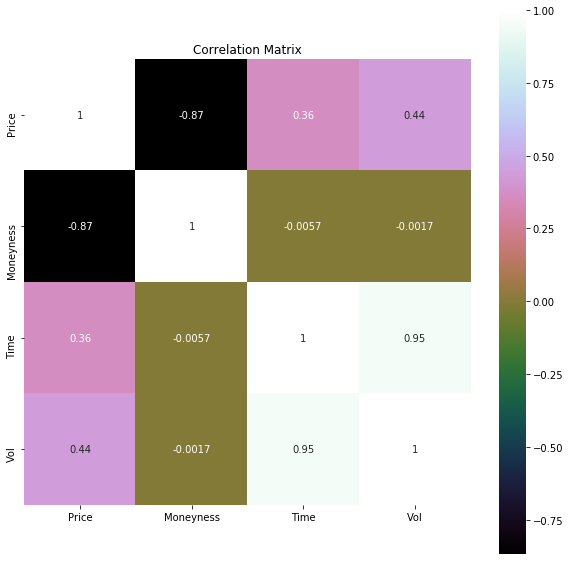

In [40]:
correlation = dataset.corr()
pyplot.figure(figsize=(10,10))
pyplot.title("Correlation Matrix")
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap="cubehelix");

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7000d0eb10>,
      dtype=object)

<Figure size 1080x1080 with 0 Axes>

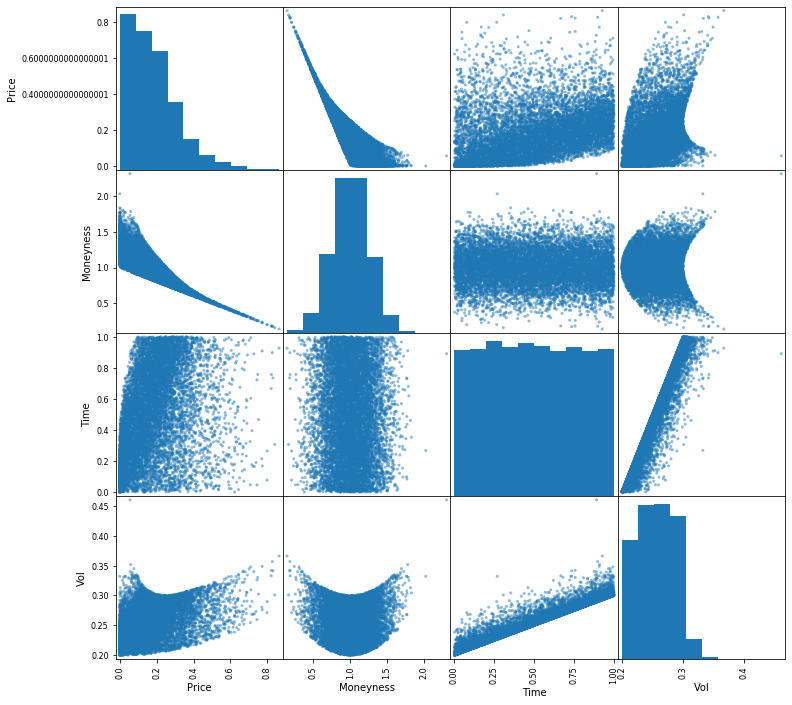

In [41]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))


#### 4. Data Preparation and Analysis



In [49]:
bestfeature = SelectKBest(k="all",score_func=f_regression)
fit = bestfeature.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(["Moneyness","Time","Vol"])
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
Moneyness,30455.892
Vol,2373.817
Time,1535.802


## 5. Evaluate models

In [51]:
validation_size = 0.2

train_size = int(len(X)*(1-validation_size))
X_train,X_test = X[:train_size],X[train_size:]
Y_train,Y_test = Y[:train_size],Y[train_size:]



In [65]:
num_folds = 10
seed = 7
scoring = "neg_mean_squared_error"

### 5.2. Compare Models and Algorithms

In [56]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(("RID",Ridge()))

In [58]:
models.append(("MLP",MLPRegressor()))


In [59]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [74]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    k_fold = KFold(n_splits=num_folds)
    cv_results = -1*cross_val_score(model,X_train,Y_train,cv=k_fold,scoring=scoring)
    kfold_results.append(cv_results)
    
    res = model.fit(X_train,Y_train)
    train_result = mean_squared_error(res.predict(X_train),Y_train)
    train_results.append(train_result)
    
    test_result = mean_squared_error(res.predict(X_test),Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f"%(name,cv_results.mean(),cv_results.std(),train_result,test_result)
    print(msg)

LR: 0.000367 (0.000057) 0.000365 0.000390
LASSO: 0.018344 (0.001466) 0.018342 0.018956
EN: 0.018344 (0.001466) 0.018342 0.018956
KNN: 0.000015 (0.000007) 0.000009 0.000008
CART: 0.000010 (0.000001) 0.000000 0.000008
SVR: 0.004171 (0.000065) 0.004167 0.004139
RID: 0.001084 (0.000124) 0.001026 0.001171
MLP: 0.000031 (0.000021) 0.000015 0.000014
ABR: 0.000585 (0.000036) 0.000538 0.000547
GBR: 0.000020 (0.000001) 0.000017 0.000020
RFR: 0.000002 (0.000001) 0.000000 0.000001
ETR: 0.000001 (0.000001) 0.000000 0.000000
